Restarted decode_lab_env (Python 3.9.18)

In [5]:
from scipy.signal import welch
from decode_lab_code.readers.ioreaders import load_nwb
import matplotlib.pyplot as plt
import numpy as np
import pynapple as nap
from decode_lab_code.core.base import base
from decode_lab_code.readers.ioreaders import read_nlx
import pandas as pd

In [6]:
from decode_lab_code.analyze.spectral import spectral

In [7]:
nwbpath = '/Users/js0403/local data/2020-06-26_16-56-10 9&10eb male ACTH ELS/nwbfile.nwb'

In [8]:
self = spectral(nwbpath)

     start_time    stop_time    tags
id                                  
0   8145.353771  8446.868771  [rec0]
1   8491.112771  9466.121771  [rec1]


In [9]:
self.history

['nwbfile: the full nwbfile, read lazily',
 'unit_data: unit data and corresponding times, as read with pynapple',
 'csc_data: lfp data and corresponding times, as read using pynapple',
 'csc_data_names: names of lfp channels and their corresponding indices to lfp_data',
 'rec_times: recording start and stop times, as retrieved from pynapple',
 'csc_times: csc timestamps',
 'fs: estimated sampling rate from the first .ncs file']

In [10]:
self.nwbfile = load_nwb(nwbpath=nwbpath)
self.events = self.nwbfile.epochs.to_dataframe()
self.csc_data_names = self.nwbfile.electrodes.to_dataframe()['label']
#self.rec_times = self.csc_data[0].time_support        

print(self.events)
# get unit data

self.unit_data = nap.load_file(nwbpath)['units']
# get csc data

csc_data = nap.load_file(nwbpath)['ElectricalSeries']
csc_times = self.nwbfile.acquisition['ElectricalSeries'].timestamps[:]
# estimate sampling rate

start_time = self.nwbfile.epochs.to_dataframe()['start_time'][0]
end_time = self.nwbfile.epochs.to_dataframe()['stop_time'][0]
temp_data = csc_data[0].data()
numsamples = len(temp_data[np.where(csc_times==start_time)[0][0]:np.where(csc_times==end_time)[0][0]])
self.fs = np.round(numsamples/(end_time-start_time)).astype(float)
# get signal from separate start/stop times

start_times = [i for i in self.events.start_time] # get times
end_times = [i for i in self.events.stop_time] # get times
start_idx = []; end_idx = []
for i in start_times:
    start_idx.append(np.where(csc_times==i))

for i in end_times:
    end_idx.append(np.where(csc_times==i))
# sanity check

if len(start_times) != len(end_times):
    ValueError("start_times do not match end times - something is wrong with the recording or extraction")
# organize data into pandas array (TsdFrame) - organizing features are recording, time(neuralynx), time(sec)
# TODO: Include helper functions to include epochs

rec_var = np.zeros(csc_data.shape[0]); times = []
for i in range(len(start_times)):
    rec_var[start_idx[i][0][0]:end_idx[i][0][0]+1]=i+1
    numsamples = np.where(rec_var==float(i+1))[0].shape[0]
    times.append(np.linspace(0,numsamples/self.fs,numsamples))

times_data = np.hstack(times)

     start_time    stop_time    tags
id                                  
0   8145.353771  8446.868771  [rec0]
1   8491.112771  9466.121771  [rec1]


In [11]:
times_data

array([0.00000000e+00, 3.12500032e-05, 6.25000065e-05, ...,
       9.75008969e+02, 9.75009000e+02, 9.75009031e+02])

In [12]:
import matplotlib.pyplot as plt

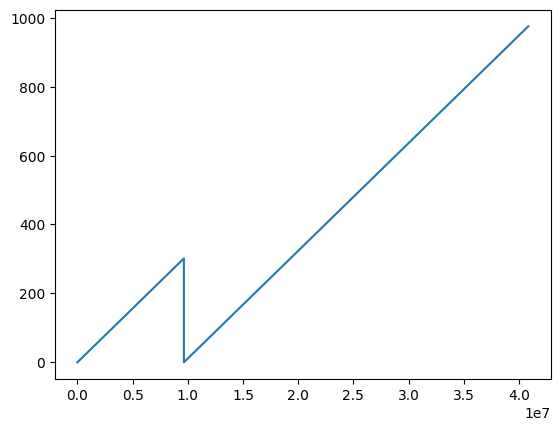

In [13]:
plt.plot(times_data)

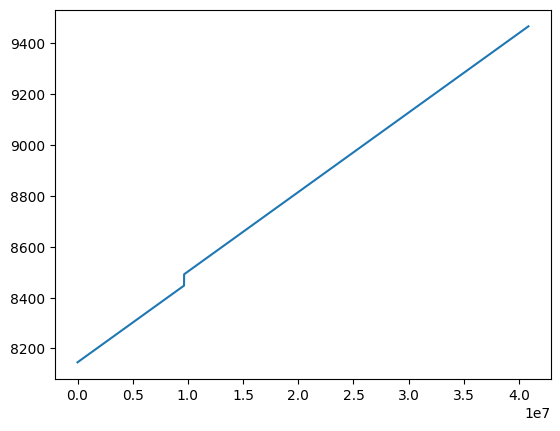

In [14]:
plt.plot(csc_times)

In [15]:
times_interp = np.linspace(csc_times[0],csc_times[-1],len(csc_times))

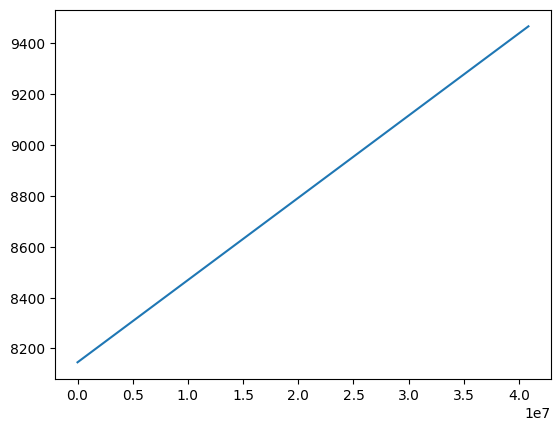

In [16]:
plt.plot(times_interp)

In [17]:
times_interp[-1]

9466.121771

In [18]:
csc_times[-1]

9466.121771

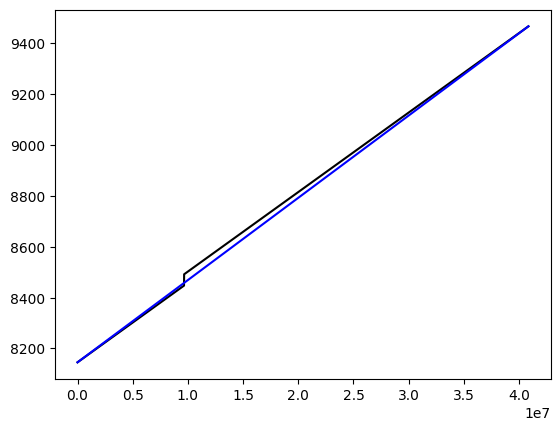

In [19]:
plt.plot(csc_times,'k')
plt.plot(times_interp,'b')

In [20]:
print("The index of 15000000:",csc_times[15000000],times_interp[15000000])

The index of 15000000: 8658.34773975 8630.35051594475


In [21]:
print("The timestamps are offset and so correlating to behavior will be inaccurate. This propogates systematically with more start/stops. Not an issue if comparing relative times (csc spikes to csc lfp)")

The timestamps are offset and so correlating to behavior will be inaccurate. This propogates systematically with more start/stops. Not an issue if comparing relative times (csc spikes to csc lfp)


In [22]:
print("You have to identify starts and stops, then linspace between those points. You should double check that any data was collected outside of that time frame, but that might be reader specific")

You have to identify starts and stops, then linspace between those points. You should double check that any data was collected outside of that time frame, but that might be reader specific
